In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium

In [4]:

# read the AirBnB csv file into pandas, change all the addresses to be upper case to later match city data
airbnb_list = pd.read_csv('../data/cville_airbnb_locations.csv')
airbnb_list.dropna(subset=['address'], inplace=True)
airbnb_list['address'] = airbnb_list['address'].str.upper()


In [5]:
# read the city parcel data with geopandas, make a column for full address by combining Street Numer and Street Name making sure to put space in middle
cville_parcels = gpd.read_file('https://opendata.arcgis.com/datasets/d11cb8b656164c85bce532cd2f2809ea_74.geojson')
cville_parcels['fulladdress'] = cville_parcels.StreetNumber+' '+cville_parcels.StreetName
cville_parcels.drop_duplicates('fulladdress', inplace=True)
print (cville_parcels.columns)


Index(['OBJECTID', 'FileType', 'GeoParcelIdentificationNumber',
       'LegalDescription', 'LotSquareFeet', 'OwnerName', 'ParcelMap',
       'ParcelNumber', 'StreetName', 'StreetNumber', 'Unit', 'UseCode',
       'ZipCode', 'Zone', 'geometry', 'fulladdress'],
      dtype='object')


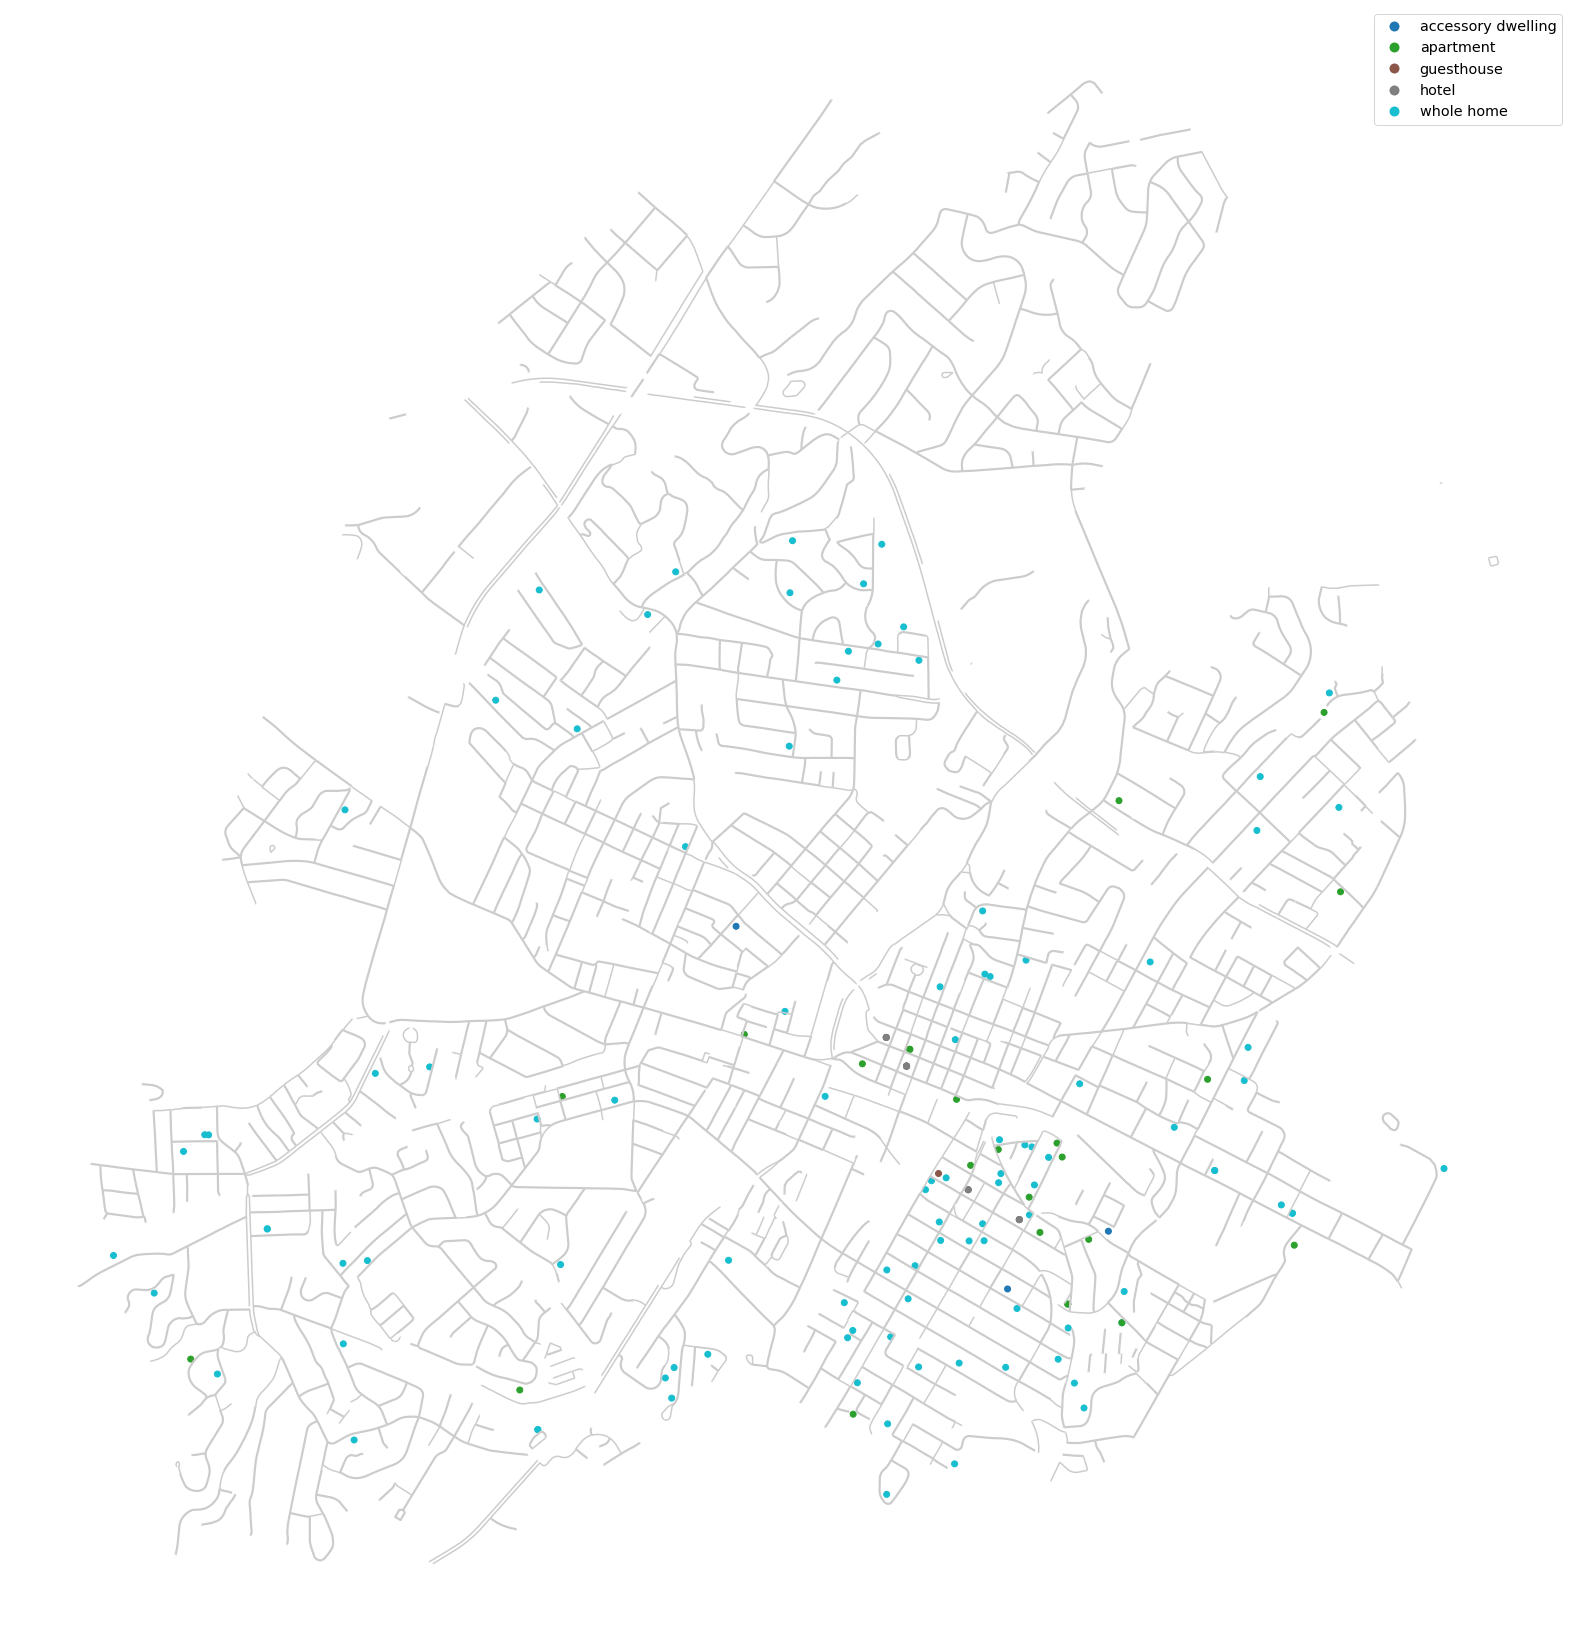

In [6]:
# merge the AirBnB list and city parcels based on the address columns with number and street
parcels_and_airbnb = pd.merge(airbnb_list, cville_parcels, left_on='address', right_on='fulladdress', how='left')
not_mapped = parcels_and_airbnb[parcels_and_airbnb.fulladdress.isnull()]
parcels_and_airbnb.dropna(subset=['geometry'], inplace=True)
parcels_and_airbnb.reset_index(inplace=True)


#read the Cville Streets file to give things more context in the plot
cville_streets = gpd.read_file('https://opendata.arcgis.com/datasets/e5a3e226dd9d4399aa014858f489852a_60.geojson')

# find those addresses that show up post merge more than twice....those are probaby hotels, so change their type
parcels_and_airbnb['address_count'] = parcels_and_airbnb.groupby('address').address.transform('count')
parcels_and_airbnb.loc[parcels_and_airbnb['address_count'] > 2, 'type'] = 'hotel'
parcels_and_airbnb.rename(columns={'type':'rental_type'}, inplace=True)

# make it so we can map the merged data frame again
airbnb_to_map = gpd.GeoDataFrame(parcels_and_airbnb, geometry ='geometry')

# make pretty plot big enough to see with street and AirBnB addresses where color relates to type of rental. Give a legend, turn off plot axes
fig, ax = plt.subplots(figsize=(30,30))
cville_streets.plot(ax=ax, color='0.8')
airbnb_to_map.plot(ax=ax, column='rental_type', legend=True, legend_kwds={'fontsize':'x-large'})
plt.axis('off')
plt.show()


In [7]:
airbnb_to_map

,index,address,link,rental_type,guest_capacity,location_notes,management_or_owner,Unnamed: 6,Unnamed: 7,OBJECTID,...,ParcelNumber,StreetName,StreetNumber,Unit,UseCode,ZipCode,Zone,geometry,fulladdress,address_count
0,0,203 DOUGLAS AVE,https://www.airbnb.com/rooms/17337587,apartment,4,NaN,NaN,NaN,NaN,11890.0,...,580358D00,DOUGLAS AVE,203,,201,22902,PUD,POINT (-78.47370 38.02717),203 DOUGLAS AVE,1
1,1,1110 MYRTLE ST,https://www.airbnb.com/rooms/9129723,accessory dwelling,3,The Belmont Flat,Stay Charlottesville,NaN,NaN,9884.0,...,570134000,MYRTLE ST,1110,,210,22902,R-2,POINT (-78.47108 38.02363),1110 MYRTLE ST,1
2,2,1308 HAMPTON ST,https://www.airbnb.com/rooms/27719797,whole home,4,NaN,NaN,NaN,NaN,10096.0,...,570123280,HAMPTON ST,1308,,210,22902,R-1S,POINT (-78.47039 38.01996),1308 HAMPTON ST,2
3,3,1308 HAMPTON ST,https://www.airbnb.com/rooms/27576154,apartment,4,NaN,NaN,NaN,NaN,10096.0,...,570123280,HAMPTON ST,1308,,210,22902,R-1S,POINT (-78.47039 38.01996),1308 HAMPTON ST,2
4,4,227 DOUGLAS AVE,https://www.airbnb.com/rooms/22626013,apartment,3,NaN,NaN,NaN,NaN,10275.0,...,580348100,DOUGLAS AVE,227,,223,22902,NCC,POINT (-78.47512 38.02500),227 DOUGLAS AVE,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,147,1023 KING ST,https://airbnb.com/rooms/21692947,apartment,2,NaN,NaN,NaN,NaN,3057.0,...,230036000,KING ST,1023,,212,22901,R-1S,POINT (-78.49891 38.02904),1023 KING ST,1
144,148,1200 KING ST,https://airbnb.com/rooms/47520874,whole home,4,NaN,Blue Ridge B&B,NaN,NaN,3116.0,...,230078000,KING ST,1200,,210,22903,R-1S,POINT (-78.50020 38.02814),1200 KING ST,1
145,149,917 CHERRY AVE,https://airbnb.com/rooms/14932235,whole home,8,NaN,Stay Charlottesville,NaN,,4741.0,...,300136000,CHERRY AVE,917,,210,22903,R-1S,POINT (-78.49624 38.02889),917 CHERRY AVE,1
146,150,513 VALLEY RD,https://https://airbnb.com/rooms/9274661,whole home,7,NaN,NaN,NaN,NaN,1360.0,...,110040000,VALLEY RD,513,,210,22903,R-1SUH,POINT (-78.50567 38.03023),513 VALLEY RD,1


In [8]:
m = folium.Map(location=[38.03185, -78.477], zoom_start=14, tiles = 'cartodb positron')

# insert multiple markers, iterate through list
# add a different color marker and icon associated with each type of AirBnB



geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in airbnb_to_map.geometry]
airbnb_to_map.loc[airbnb_to_map['rental_type'] == 'accessory dwelling', 'rental_type' ] = "guesthouse"

print (airbnb_to_map.type)

i = 0
for coordinates in geo_df_list:
    #assign a color marker for the type of volcano, Strato being the most common
    if airbnb_to_map.rental_type.iloc[i] == "whole home":
        icon_type = "home"
        type_color = "cadetblue"
        icon_prefix='fa'
    elif airbnb_to_map.rental_type.iloc[i] == "guesthouse":
        type_color = "purple"
        icon_type = 'key'
        icon_prefix = 'fa'
    elif airbnb_to_map.rental_type[i] == "apartment":
        type_color = "lightblue"
        icon_type = "bed"
        icon_prefix='fa'
    elif airbnb_to_map.rental_type[i] == "hotel":
        icon_type = 'building'
        type_color = "lightgray"
        icon_prefix= 'fa'
    else:
        type_color = "purple"
        icon_type = 'bath'
        prefix = 'fa'
        
    if airbnb_to_map.guest_capacity[i] > 6:
        type_color = 'red'

    displ_tooltip = ("<b>Address:</b> "+airbnb_to_map.address[i]+"<br>"
            "<b>Type:</b> "+airbnb_to_map.rental_type[i]+"<br>"
            "<b>Guest Capacity:</b> "+str(airbnb_to_map.guest_capacity[i])+"<br>"
            '<b>Link:</b> <a href="'+airbnb_to_map.link[i]+'">'+airbnb_to_map.link[i]+'</a> <br>')

    #now place the markers with the popup labels and data
    m.add_child(folium.Marker(location = coordinates,
                            icon = folium.Icon(color = type_color, icon = icon_type, prefix =icon_prefix), popup = displ_tooltip))
    i = i + 1


m.save("cville_airbnbs.html")

0      Point
1      Point
2      Point
3      Point
4      Point
       ...  
143    Point
144    Point
145    Point
146    Point
147    Point
Length: 148, dtype: object
